# Experiments w Kernel Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a higher-order Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
x_i^{(t)} &\sim P(\cdot | x_{i-1}^{(t)}, \ldots, x_{i-m}^{(t)})
\end{align*}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers

2023-08-24 13:40:47.207121: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 13:40:47.348134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 13:40:48.682253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices()

2023-08-24 13:40:51.502833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 13:40:51.942167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 13:40:51.942229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Generate Data

In [3]:
n_states = 16
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))
len(state_tuples)

256

In [4]:
transition_dict = dict()

for state_tuple in state_tuples:
    next_state = np.random.randint(n_states)
    p = np.zeros(n_states)
    p[next_state] = 1

    transition_dict[state_tuple] = p

In [5]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)
    return states_seq

In [6]:
input_seq_len = 32 # length of input sequences
mem_seq_len = 5*m # length of each memory sequence
mem_size = 16 # number of memory sequences

n_train = 400
n_test = 400

def sample_seqs_dataset(n, input_seq_len):
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for _ in range(n)])

    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    return seqs_x, seqs_y


def sample_mem_dataset(mem_seq_len, mem_size):
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1) 
         for _ in range(mem_size)])
    # mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=n)
    mem_seqs = mem_seqs

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    return mem_seqs_x, mem_seqs_y

seqs_x_train, seqs_y_train = sample_seqs_dataset(n_train, input_seq_len)
seqs_x_test, seqs_y_test = sample_seqs_dataset(n_test, input_seq_len)



# NOTE: manually add some patterns that appears in training and testing set to memory buffer 

mem_seqs_x, mem_seqs_y = sample_mem_dataset(mem_seq_len, mem_size)


# sample memory buffers randomly
mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size) for _ in range(n_train)])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size) for _ in range(n_test)])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

In [7]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (400, 32); seqs_y_train.shape: (400, 32)
mem_seqs_x_train.shape: (400, 16, 10); mem_seqs_y.shape: (400, 16, 10)


In [8]:
fit_kwargs = dict(epochs=30)

from tqdm.keras import TqdmCallback
from tqdm import tqdm
def create_callbacks():
    return [TqdmCallback(tqdm_class=tqdm)]

## Model 1: Kernel Model

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test), seqs_y_test)).batch(64)


2023-08-24 13:40:54.480782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 13:40:54.480950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 13:40:54.480978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 13:40:59.387467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 13:40:59.391056: I tensorflow/compile

In [10]:
from kernel_memory_transformer import KernelMemoryTransformer
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model1 = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], name='kernel_memory_model')

memory_model1([seqs_x_train[:64], mem_seqs_x_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model1.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model1.summary()

2023-08-24 13:41:06.544095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-24 13:41:07.325553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPos  multiple                  0         
 itionalEmbedding)                                               
                                                                 
 mem_pos_embedder_adder (Me  multiple                  0         
 moryAddPositionalEmbedding                                      
 )                                                               
                                                                 
 causal_self_attention (Cau  multiple                  16768     
 salSelfAttention)                                               
                                                                 
 global_self_attention (Glo  multiple          

  0%|          | 0/30 [00:00<?, ?epoch/s]2023-08-24 13:41:14.757275: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff82400b210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-24 13:41:14.757374: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-08-24 13:41:14.801038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-24 13:41:15.092804: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-24 13:41:15.204881: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 30/30 [01:39<00:00,  3.31s/epoch, loss=0.373, accuracy=0.893]


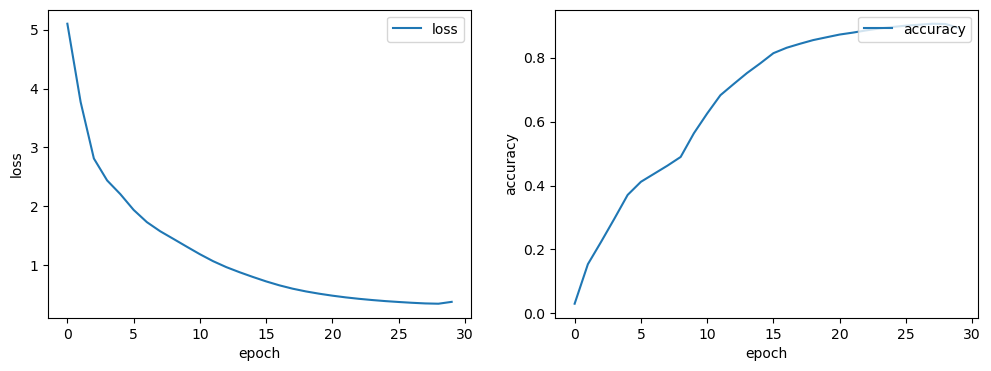

In [11]:
history1 = memory_model1.fit(train_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [12]:
memory_model1.evaluate(train_ds)
memory_model1.evaluate(test_ds)

7/7 [==============================] - 1s 170ms/step - loss: 0.3793 - accuracy: 0.8914


[0.3792690932750702, 0.891406238079071]

7/7 [==============================] - 2s 170ms/step


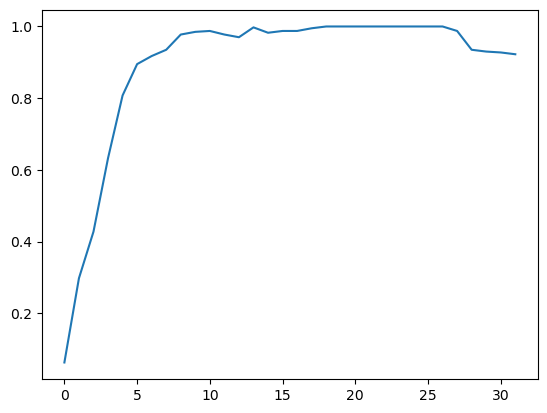

In [13]:

# plot accuracy as a function of position in sequence
preds = memory_model1.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

## Model2: Hierarchical Attention Model

In [14]:
from hierarchical_attention import MultiHeadHierarchicalAttention

train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)


In [15]:
from transformer_modules import AddPositionalEmbedding, create_positional_encoding, MemoryAddPositionalEmbedding
from transformer_modules import GlobalSelfAttention, CausalSelfAttention

class HierarchicalAttnMemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        # self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')
        self.self_attention_layer = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        # return self.self_attention_layer(seq, seq, use_causal_mask=True)
        return self.self_attention_layer(seq)

    def memory_self_attention(self, mem_seqs):
        # lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=True)
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [16]:
vocab_size = len(state_tuples)
embedding_dim = 64

memory_model2 = HierarchicalAttnMemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//3, n_heads=3, name='memory_model')

memory_model2([seqs_x_train, mem_seqs_x_train, mem_seqs_y_train]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model2.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPos  multiple                  0         
 itionalEmbedding)                                               
                                                                 
 mem_pos_embedder_adder (Me  multiple                  0         
 moryAddPositionalEmbedding                                      
 )                                                               
                                                                 
 causal_self_attention_1 (C  multiple                  16509     
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_1 (G  multiple                 

100%|██████████| 30/30 [00:57<00:00,  1.93s/epoch, loss=0.469, accuracy=0.873]


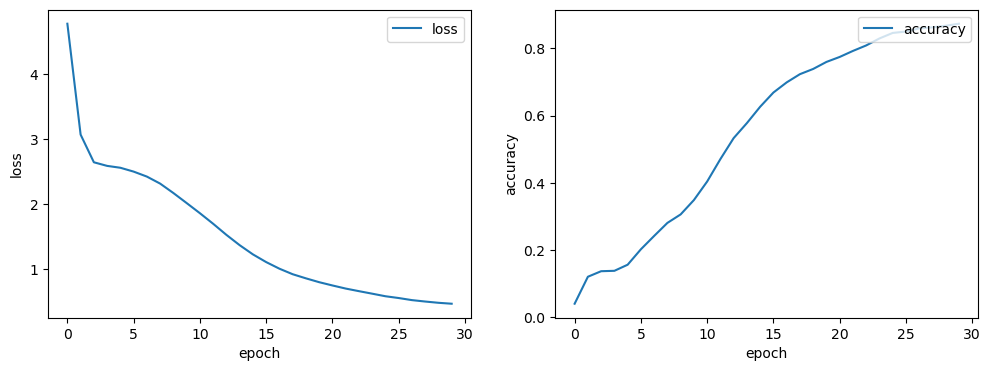

In [17]:
history2 = memory_model2.fit(train_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [18]:
memory_model2.evaluate(train_ds)
memory_model2.evaluate(test_ds)

7/7 [==============================] - 1s 115ms/step - loss: 0.5380 - accuracy: 0.8545


[0.5379666090011597, 0.8545312285423279]

7/7 [==============================] - 1s 144ms/step


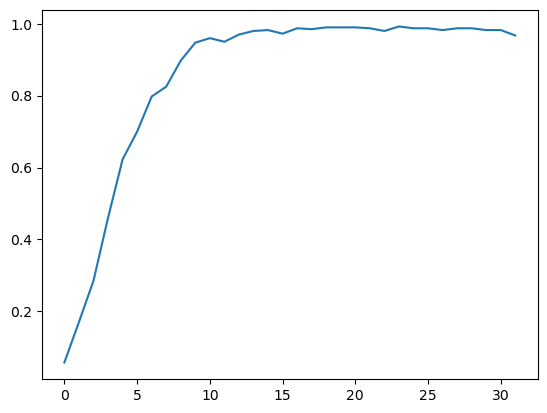

In [19]:

# plot accuracy as a function of position in sequence
preds = memory_model2.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

## Model 3: kernel model, use mem_seq_y as value in cross attention (only embedding, no self-attention on mem_seq_y)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer_cross_y(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='mem_self_attn')

        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''

        def get_memory_cross_probs(E_xt, E_yt):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs,
                key=E_xt,
                value=E_yt)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)
        
        #print(get_memory_cross_probs(embedded_mem_x_seqs[:,0,:,:], embedded_mem_y_seqs[:,0,:,:]))
        #compute cross-attention for each memory
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), (tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3]), tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3])), dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components coresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it

    def call(self, inputs):
        seq_input, memory_input_x, memory_input_y = inputs

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input_x)
        embedded_mem_y_seqs = self.embedder(memory_input_y)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
        self.alpha_it = alpha_it
        
        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs), axis=1)

        return output


In [21]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)


memory_model3 = KernelMemoryTransformer_cross_y(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], name='kernel_memory_model_cross_y')

memory_model3([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model3.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model3.summary()

Model: "kernel_memory_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPos  multiple                  0         
 itionalEmbedding)                                               
                                                                 
 mem_pos_embedder_adder (Me  multiple                  0         
 moryAddPositionalEmbedding                                      
 )                                                               
                                                                 
 causal_self_attention_2 (C  multiple                  16768     
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_2 (G  multiple  

  0%|          | 0/30 [00:00<?, ?epoch/s]

Instructions for updating:
Use fn_output_signature instead


100%|██████████| 30/30 [01:32<00:00,  3.09s/epoch, loss=1.62, accuracy=0.477]


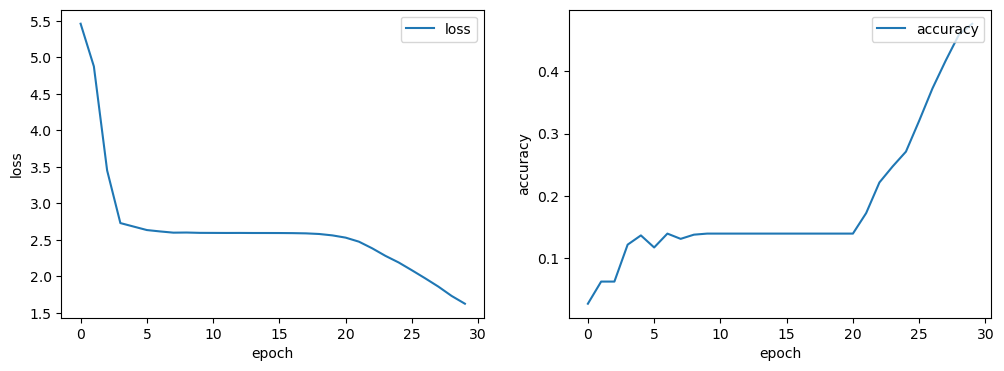

In [22]:
history3 = memory_model3.fit(train_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history3, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [23]:
memory_model3.evaluate(train_ds)
memory_model3.evaluate(test_ds)

7/7 [==============================] - 2s 219ms/step - loss: 1.5982 - accuracy: 0.4748


[1.5982253551483154, 0.47484374046325684]

7/7 [==============================] - 2s 175ms/step


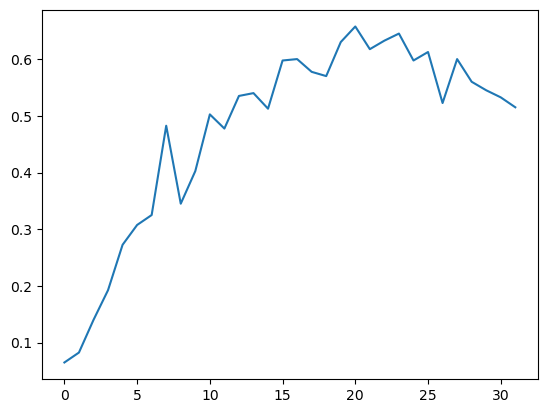

In [24]:
# plot accuracy as a function of position in sequence
preds = memory_model3.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

## Attention visualization

In [25]:
# utilities for analyzing attention patterns in hierarchical attention model

import matplotlib.pyplot as plt
from matplotlib import gridspec


def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x, **figkwargs):
    fig, ax = plt.subplots(**figkwargs)
    cmap = 'gray' if attn_.shape[-1] == 1 else None
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


def plot_attention_hierarchical(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

    fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])
    attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

In [26]:
# plot function for kernel model 1
from utils_kernel_transformer import plot_attention

In [27]:
# plot function for kernel cross attn value = y model 

from utils_kernel_transformer import plot_seq_attention

def plot_attention_cross_y(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.alpha_it[0]
    #print(attn_output_seq.shape)
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])


memory_model1
sample_input:  [[ 9  8  2 14  6 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12  0
   2 10  1 11 13  3  5  9]]
prediction: [14 14 14  6 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12  0  2
 10  1 11 13  3  5  9 10]
y: [ 8  2 14  6 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12  0  2
 10  1 11 13  3  5  9 10]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
memory_model2
sample_input:  [[ 1 13  9 12 14  7 14  4 14 13  4  9  0  9  5 14  0 14  2  3 14  5  0  6
   5  7  1  1 12  0  2 10]]
prediction: [ 1  9  2  9  4 14  4 14  4  4  9  0  9  5 14  0 14  2  3 14  5  0  6  5
  7  1  1 12  0  2 10  1]
y: [13  9 12 14  7 14  4 14 13  4  9  0  9  5 14  0 14  2  3 14  5  0  6  5
  7  1  1 12  0  2 10  1]
[False  True False False False  True  True  True False  True  True  True
  True  True  True  True  True  True  True 

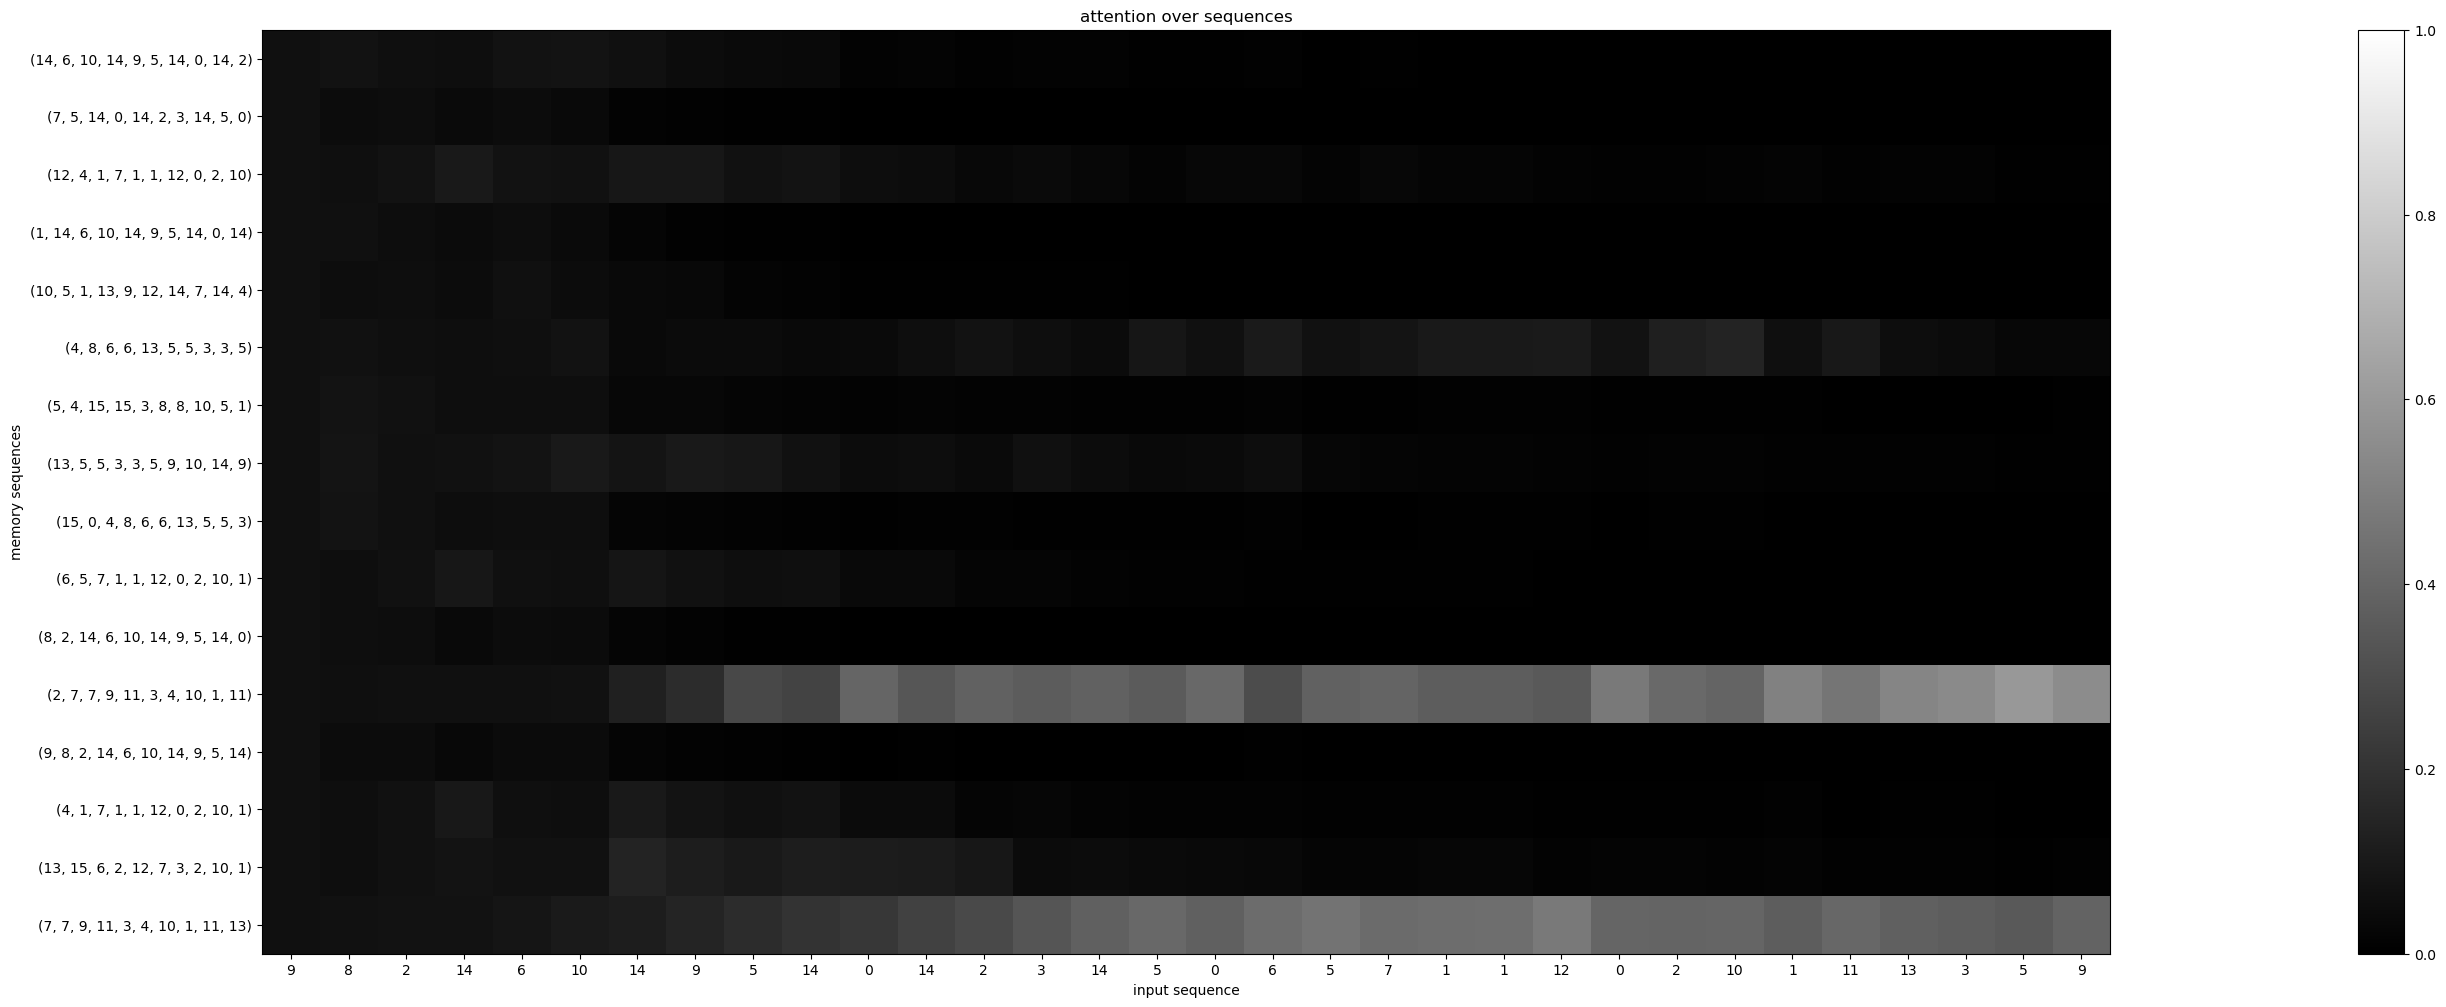

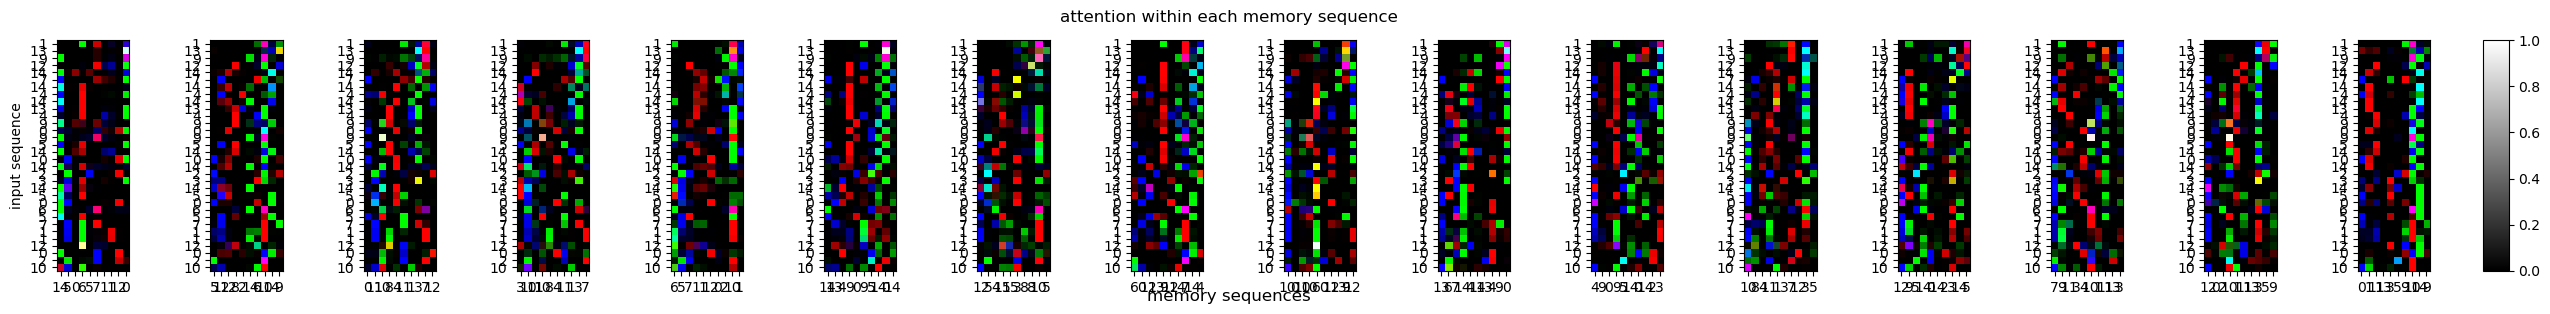

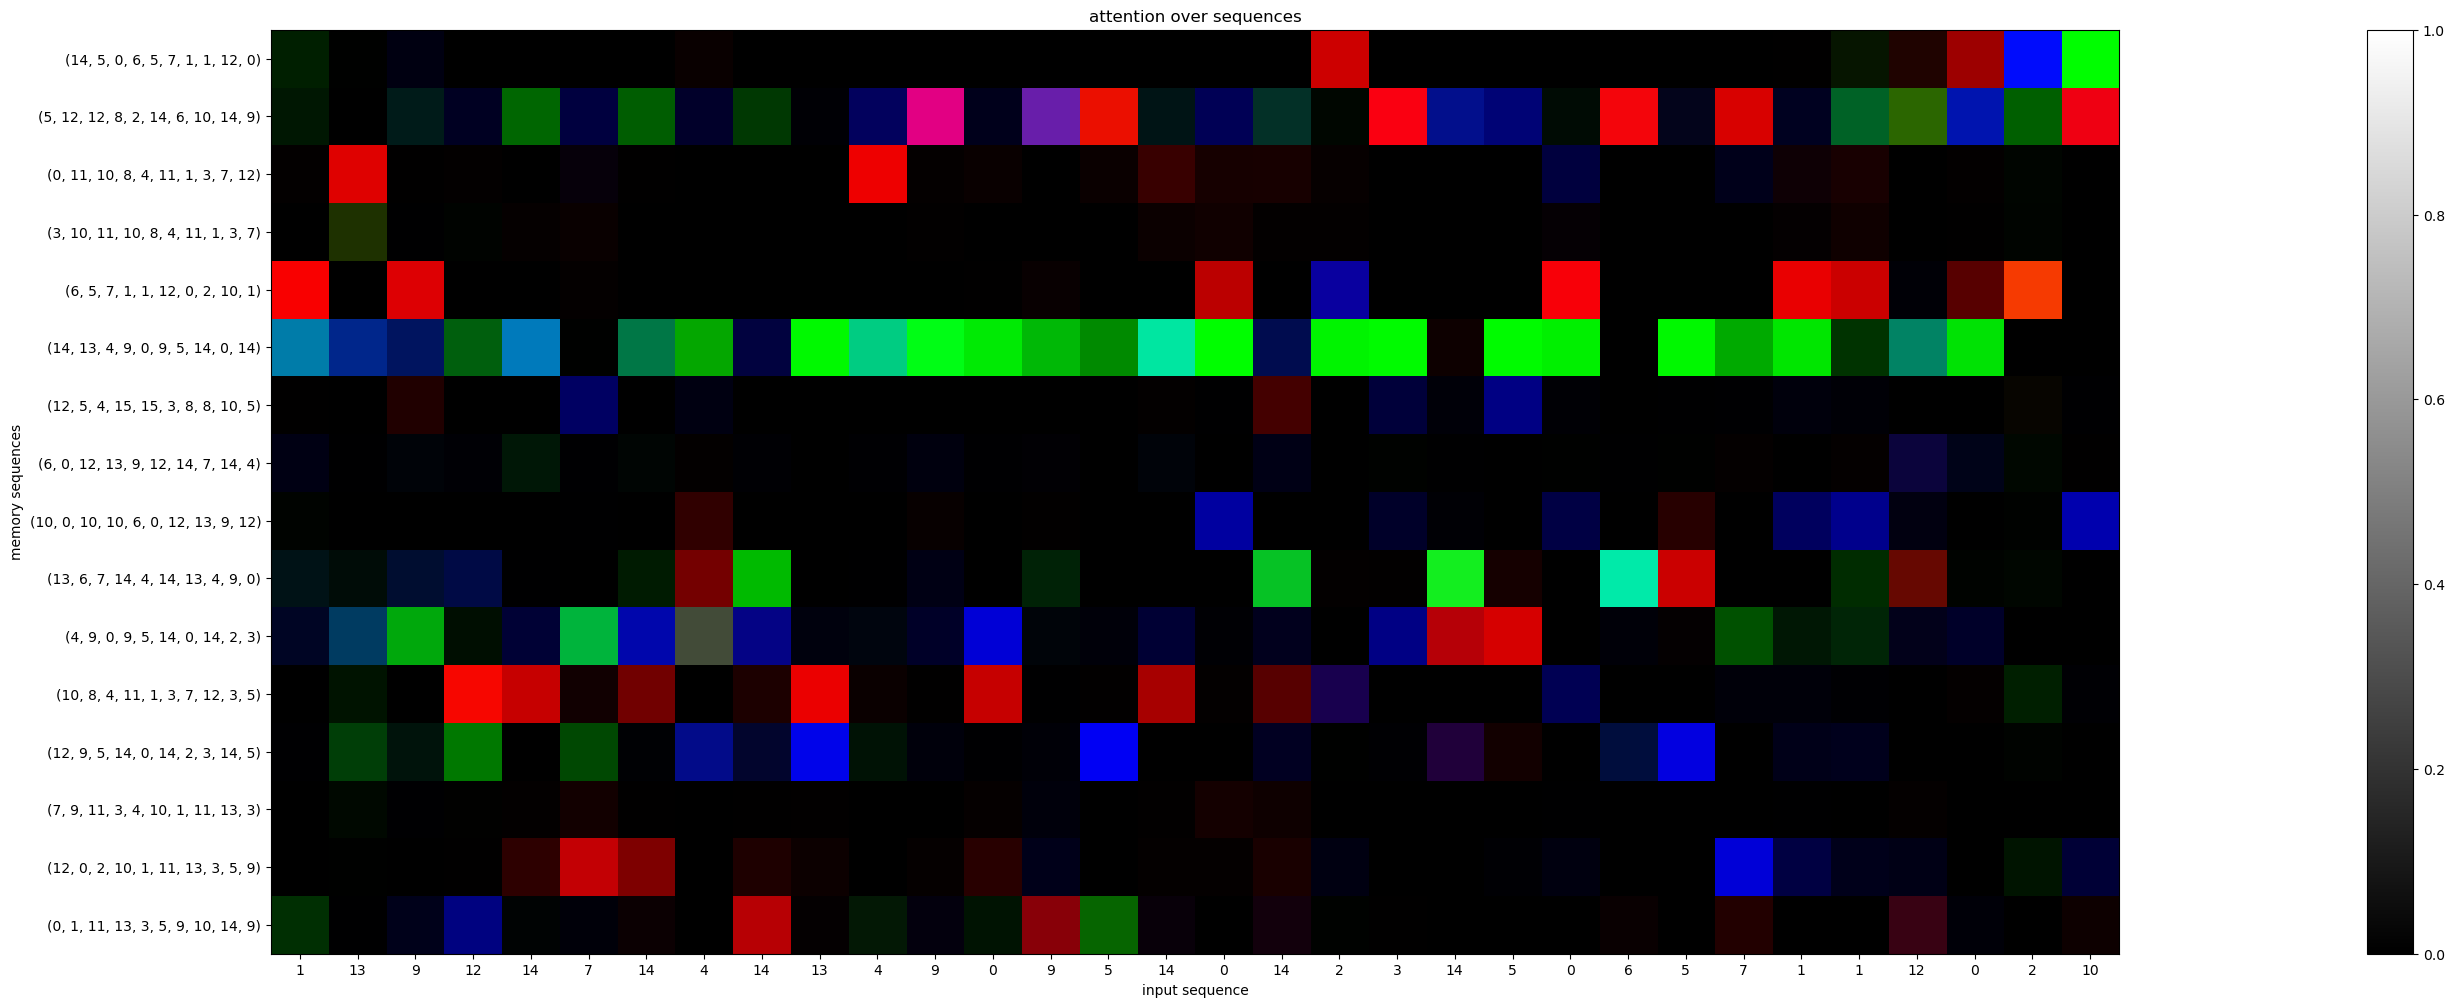

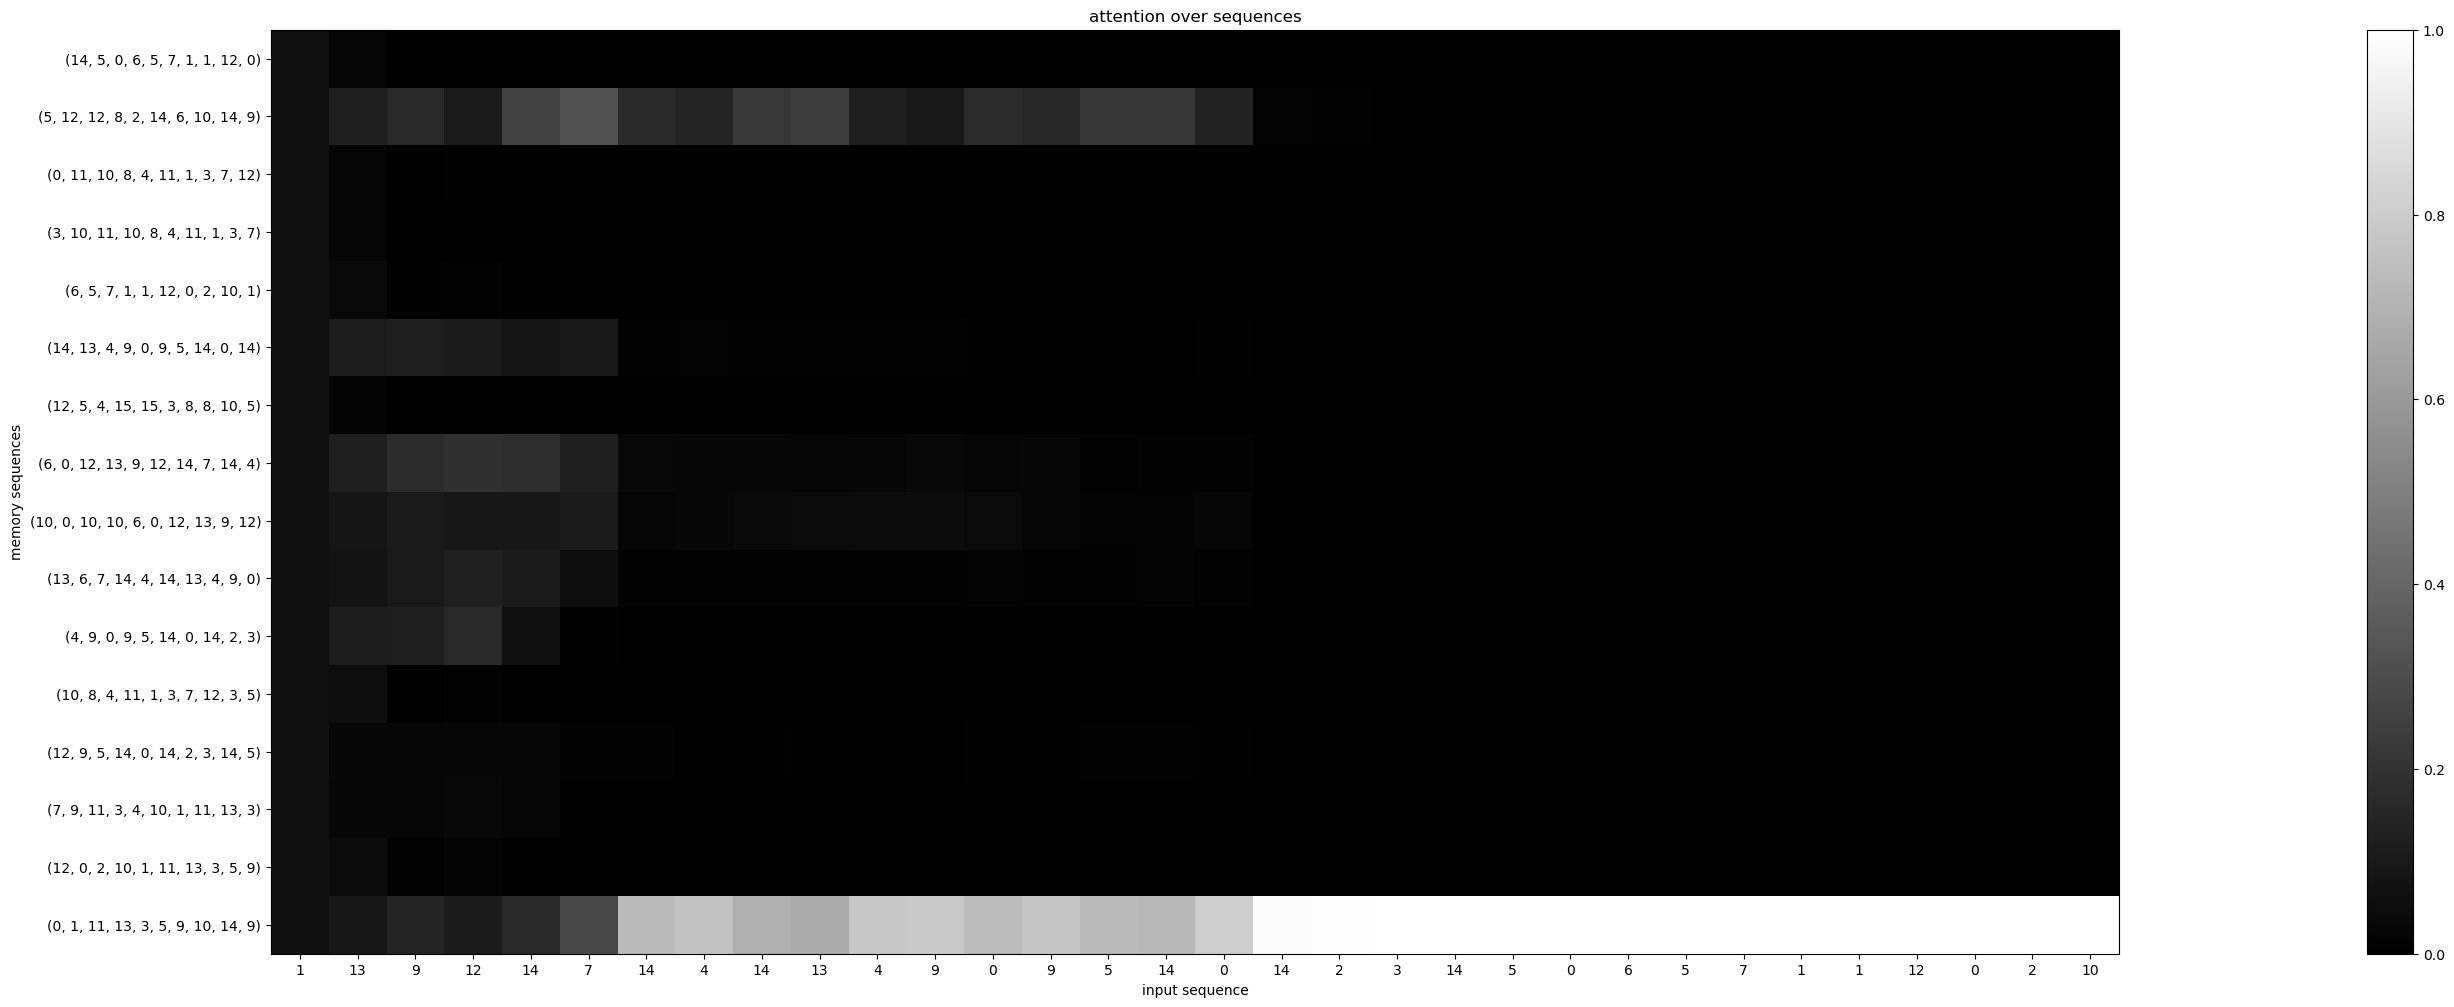

In [31]:
idx = np.random.choice(len(seqs_x_test))
print('memory_model1')
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model1)
print('memory_model2')
plot_attention_hierarchical(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
print('memory_model3')
plot_attention_cross_y(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)


memory_model1
sample_input:  [[10 13 12  3  5  9 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12
   0  2 10  1 11 13  3  5]]
prediction: [ 1  9 13  5  9 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12  0
  2 10  1 11 13  3  5  9]
y: [13 12  3  5  9 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12  0
  2 10  1 11 13  3  5  9]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
memory_model2
sample_input:  [[ 5 12 12  8  2 14  6 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1
  12  0  2 10  1 11 13  3]]
prediction: [ 1  5 13  8 10 13 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12
  0  2 10  1 11 13  3  5]
y: [12 12  8  2 14  6 10 14  9  5 14  0 14  2  3 14  5  0  6  5  7  1  1 12
  0  2 10  1 11 13  3  5]
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True 

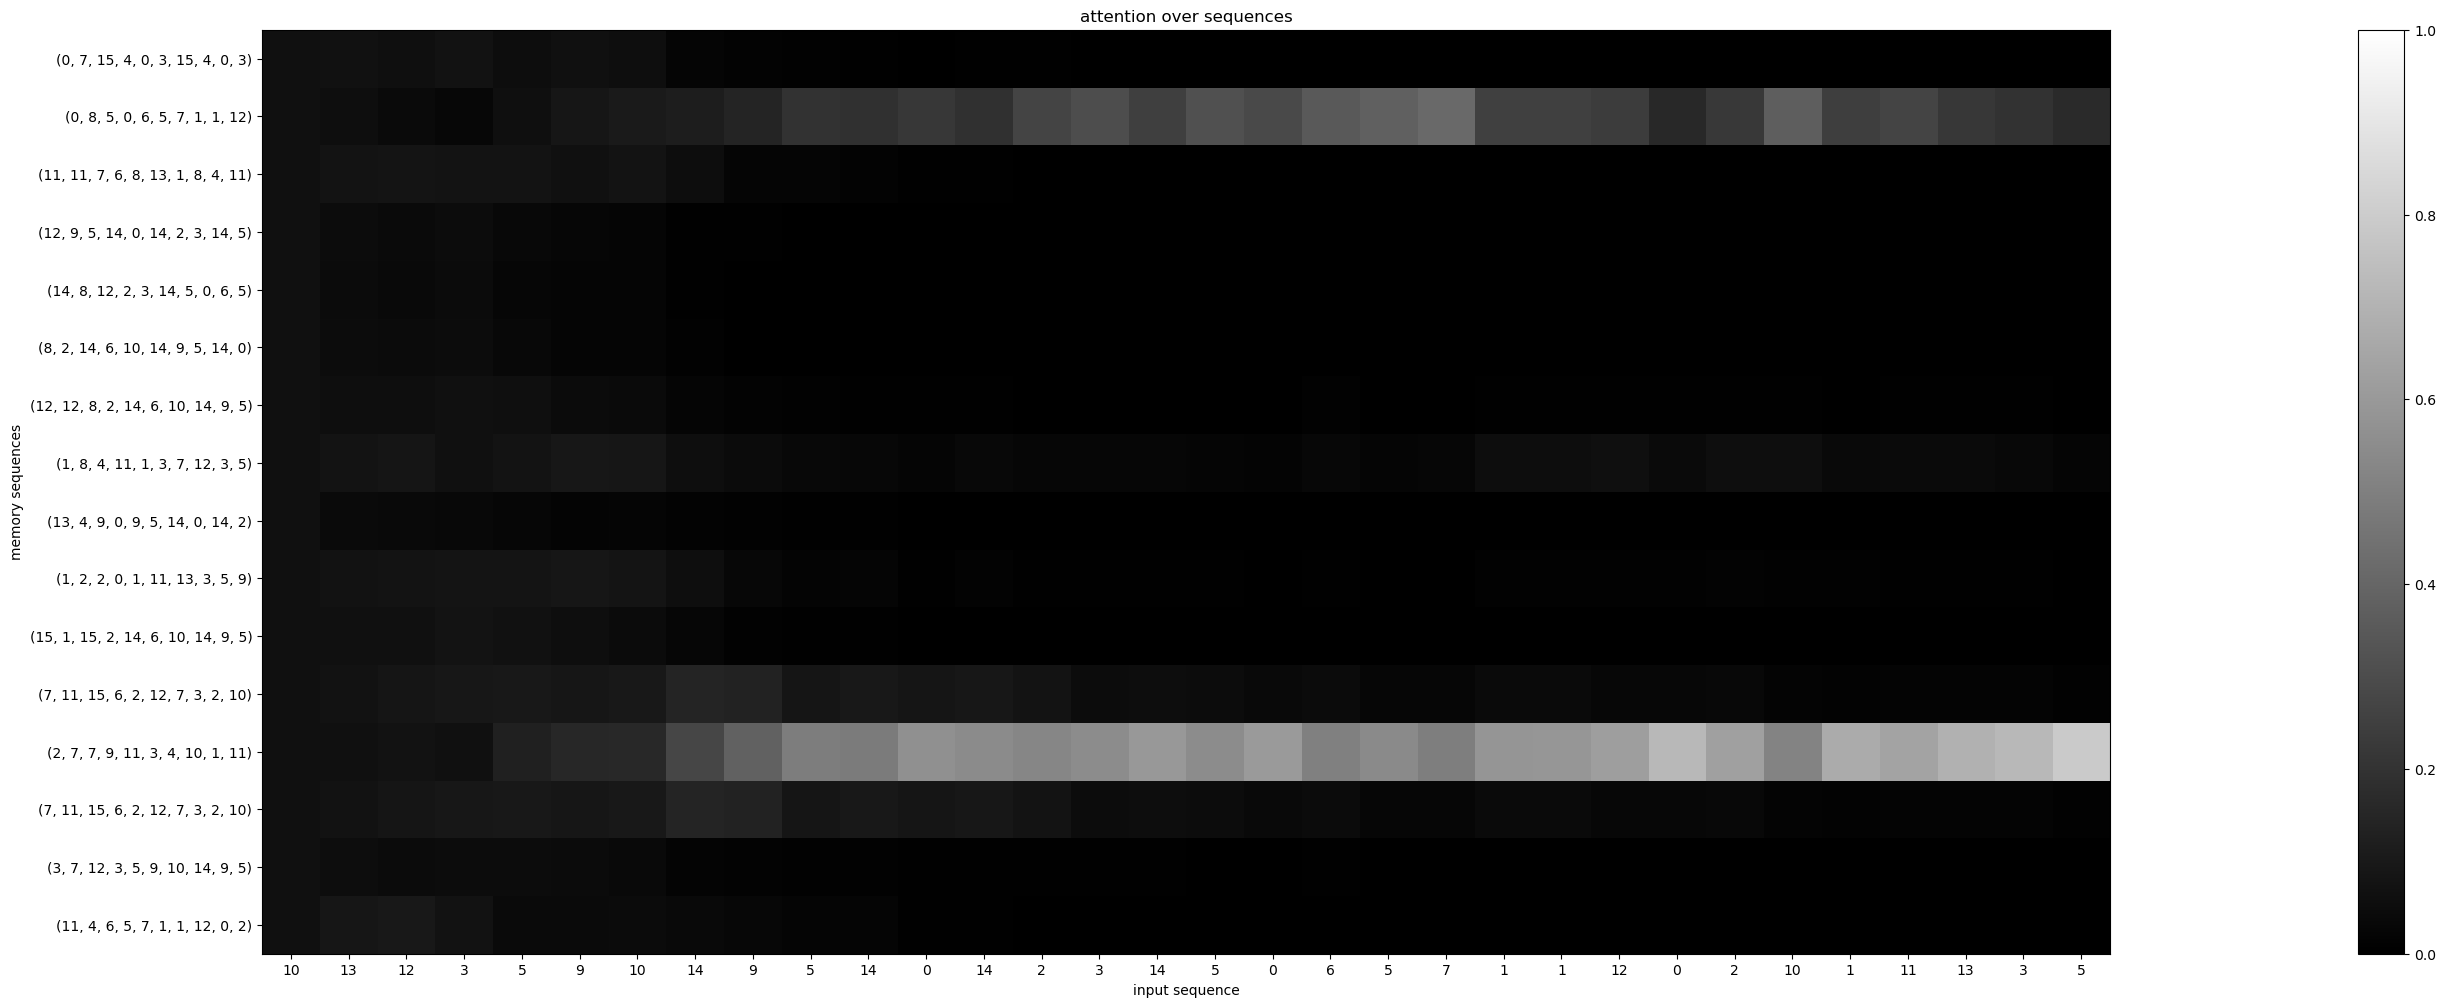

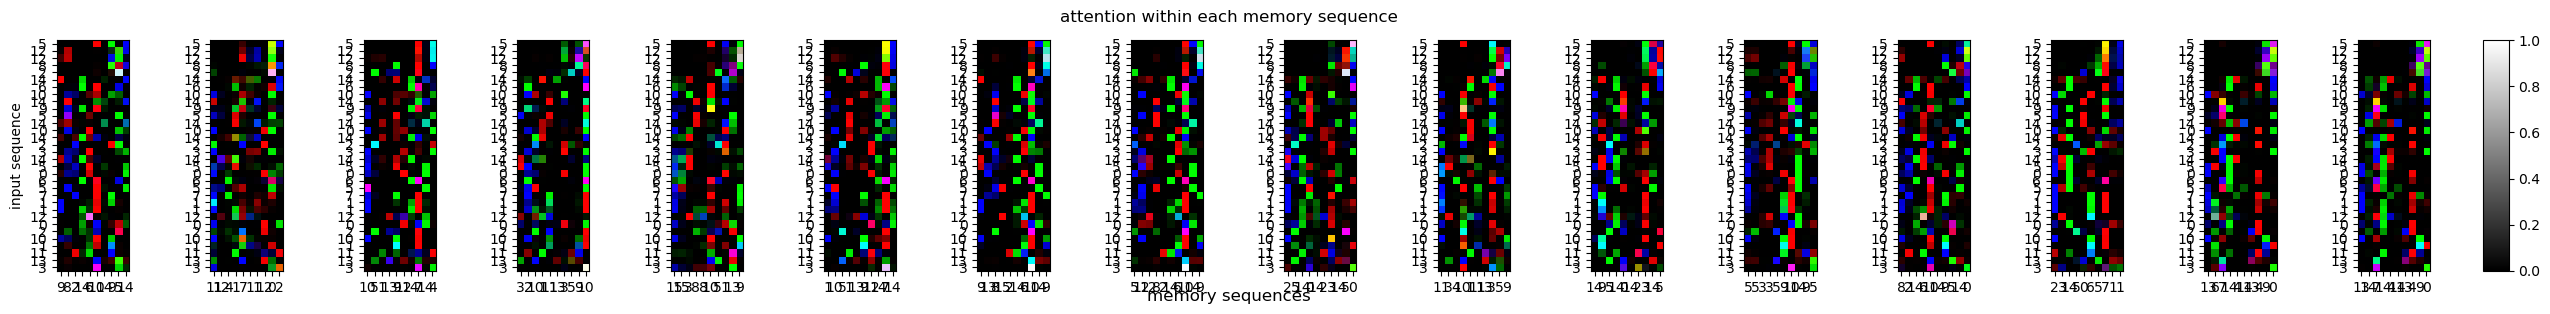

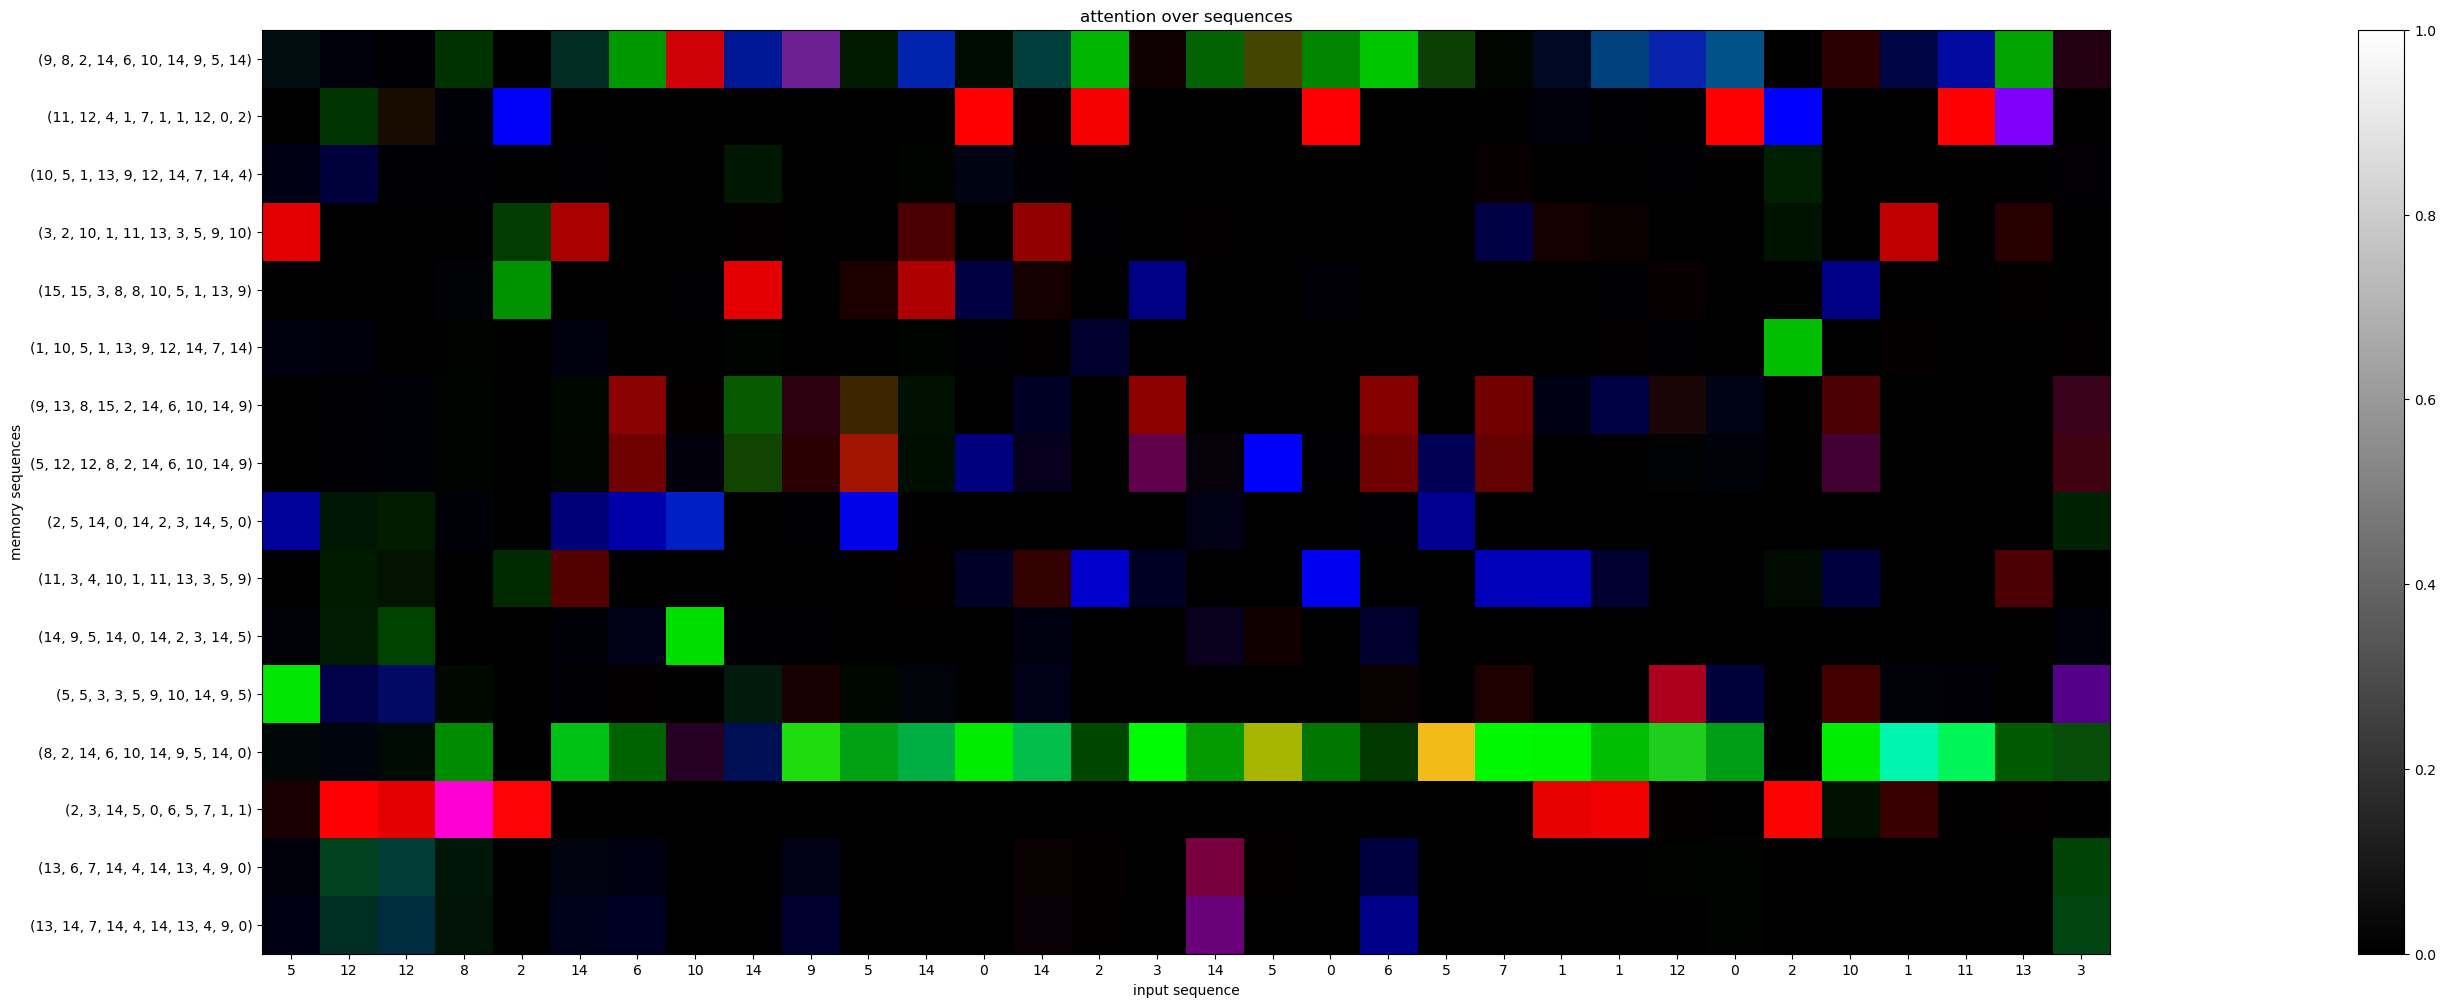

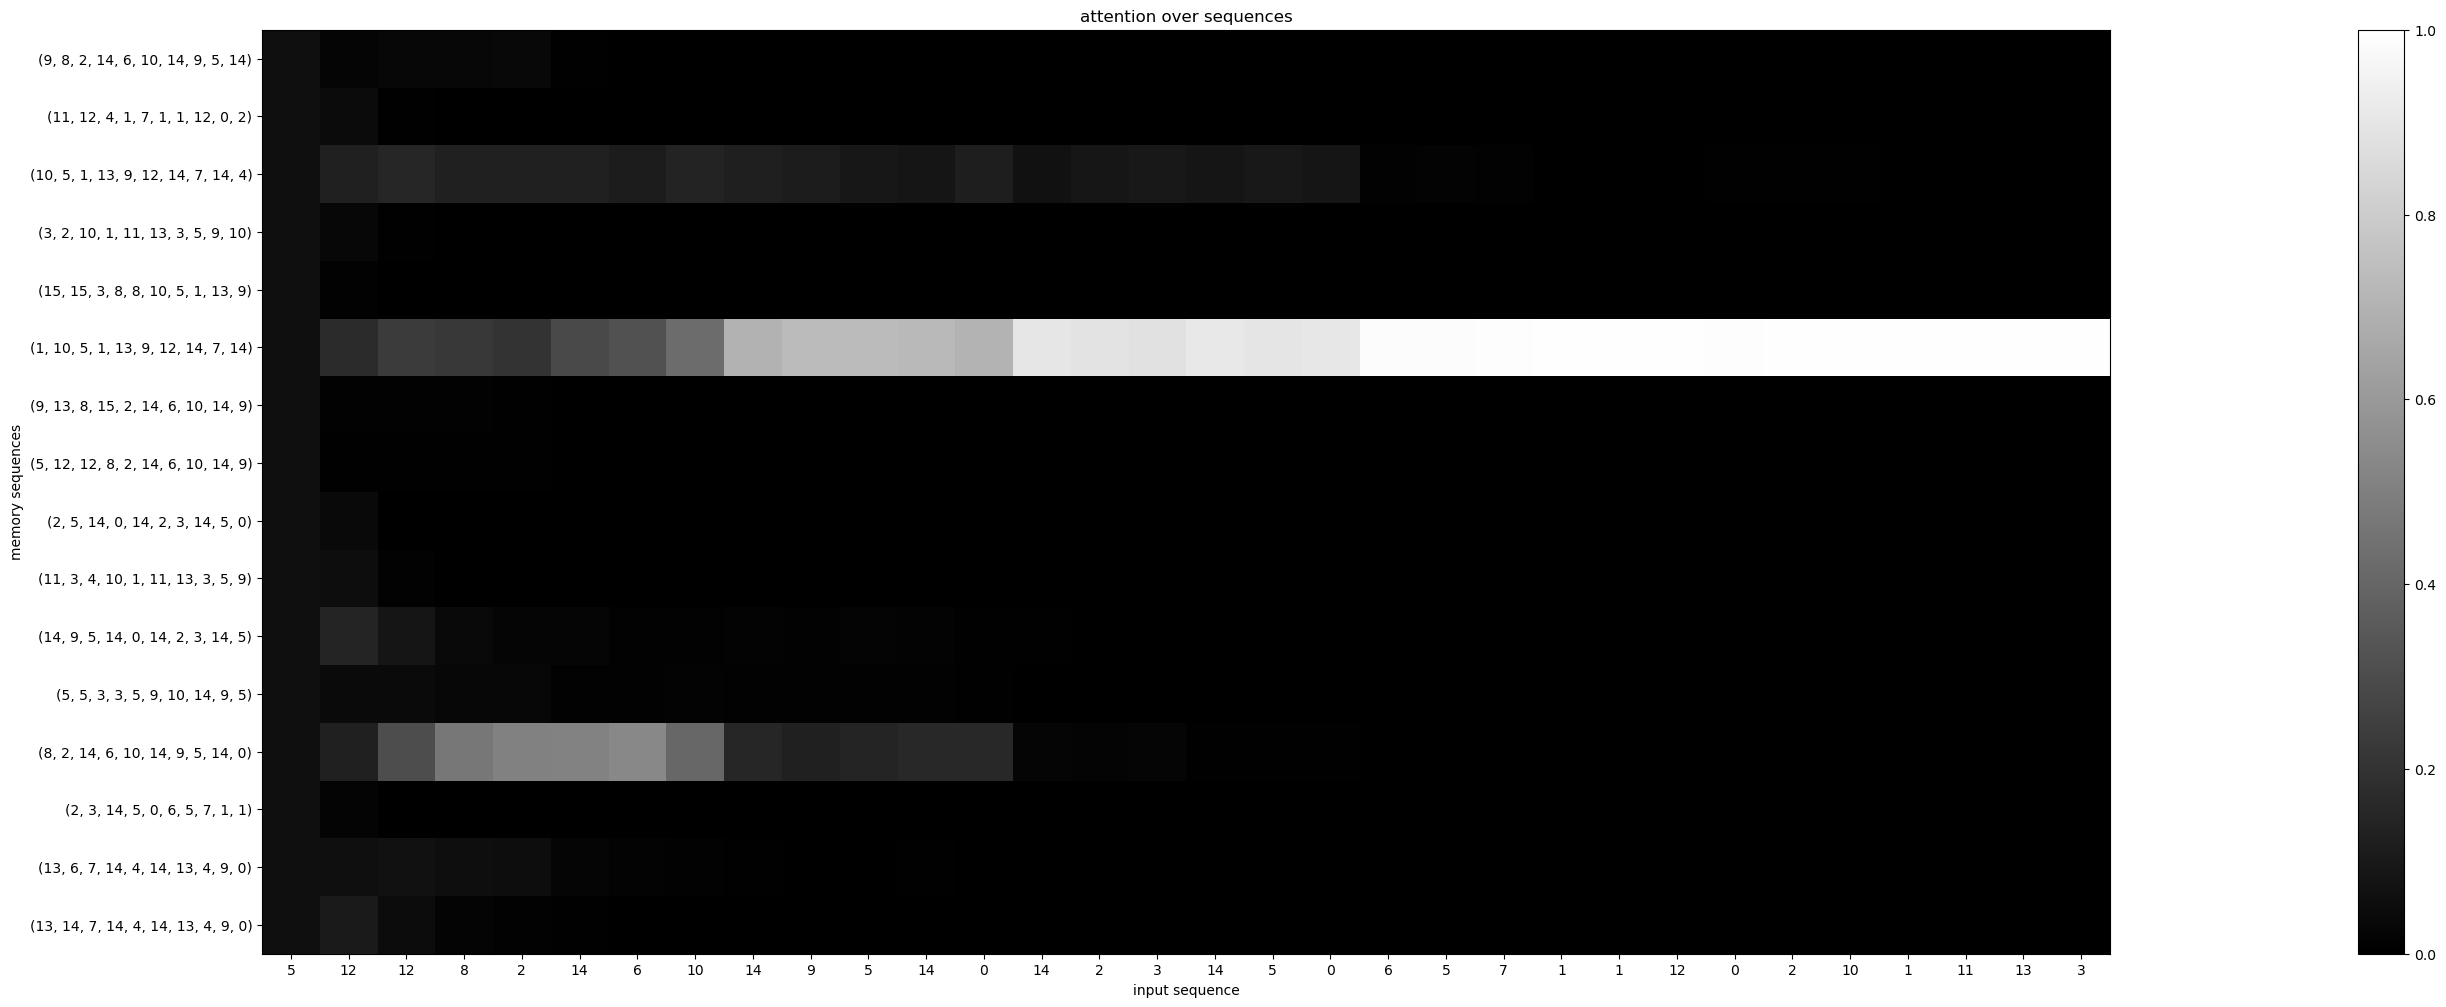

In [32]:
idx = np.random.choice(len(seqs_x_test))
print('memory_model1')
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model1)
print('memory_model2')
plot_attention_hierarchical(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
print('memory_model3')
plot_attention_cross_y(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)


memory_model1
sample_input:  [[ 0 10 10  6  0 12 13  9 12 14  7 14  4 14 13  4  9  0  9  5 14  0 14  2
   3 14  5  0  6  5  7  1]]
prediction: [ 6  1  1 10  9  0  9  5 14  7 14  4 14 13  4  9  0  9  5 14  0 14  2  3
 14  5  0  6  5  7  1  1]
y: [10 10  6  0 12 13  9 12 14  7 14  4 14 13  4  9  0  9  5 14  0 14  2  3
 14  5  0  6  5  7  1  1]
[False False False False False False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
memory_model2
sample_input:  [[15  3  8  8 10  5  1 13  9 12 14  7 14  4 14 13  4  9  0  9  5 14  0 14
   2  3 14  5  0  6  5  7]]
prediction: [13  7  4  1  1  1 11  9 12 14  0 14  4 14 13  4  9  0  9  5 14  2 14  5
  3 14  5  0  6  5  7  1]
y: [ 3  8  8 10  5  1 13  9 12 14  7 14  4 14 13  4  9  0  9  5 14  0 14  2
  3 14  5  0  6  5  7  1]
[False False False False False  True False  True  True  True False  True
  True  True  True  True  True  True  True 

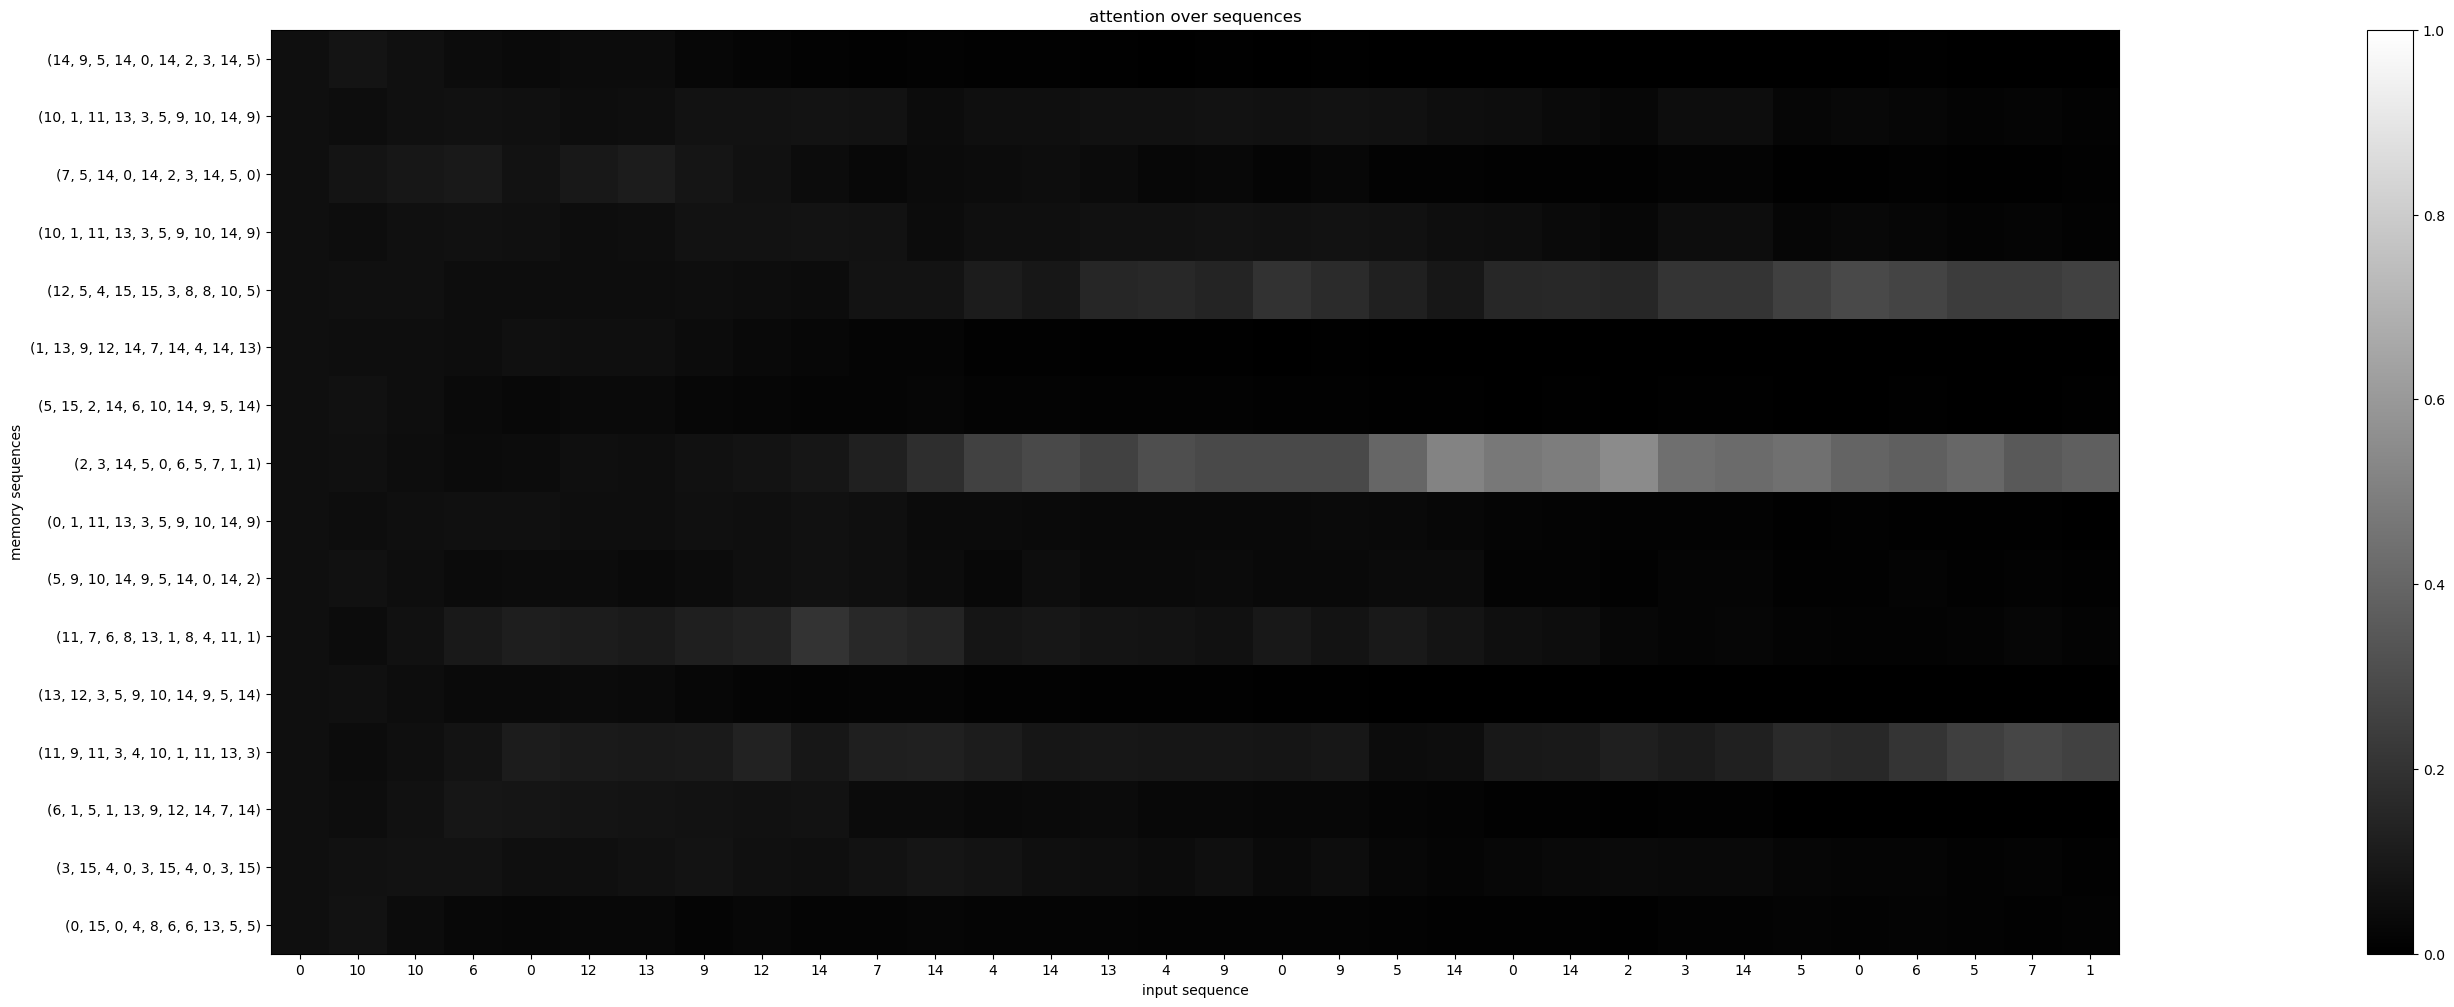

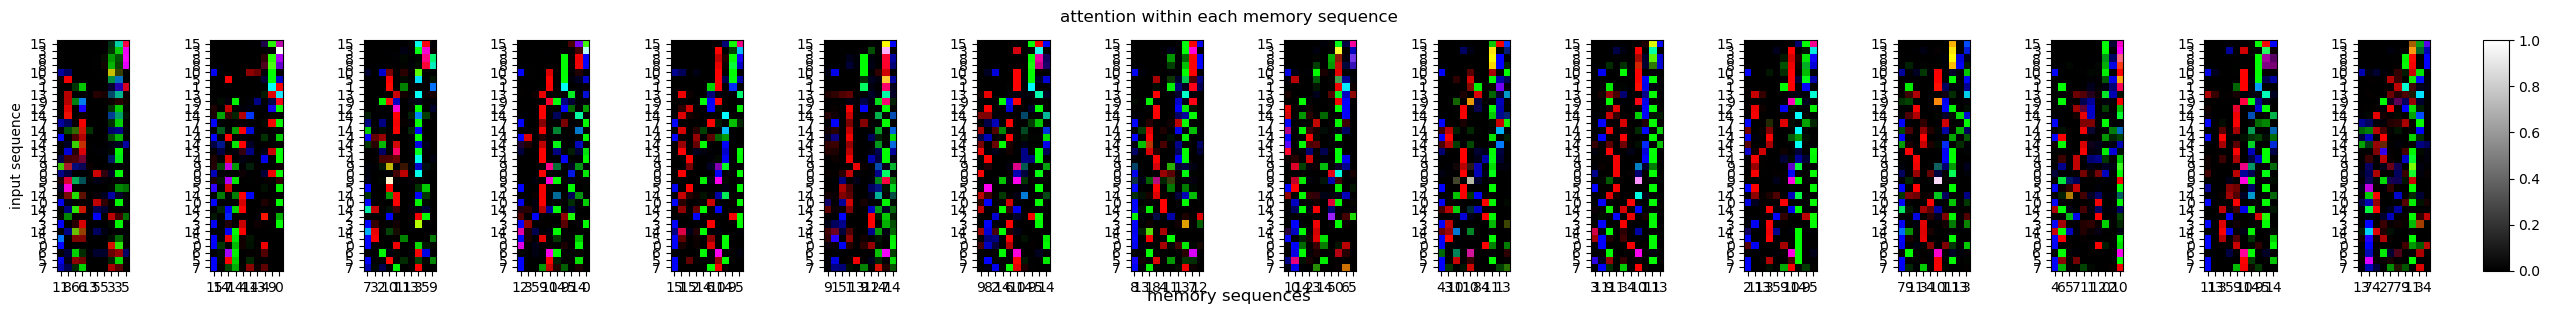

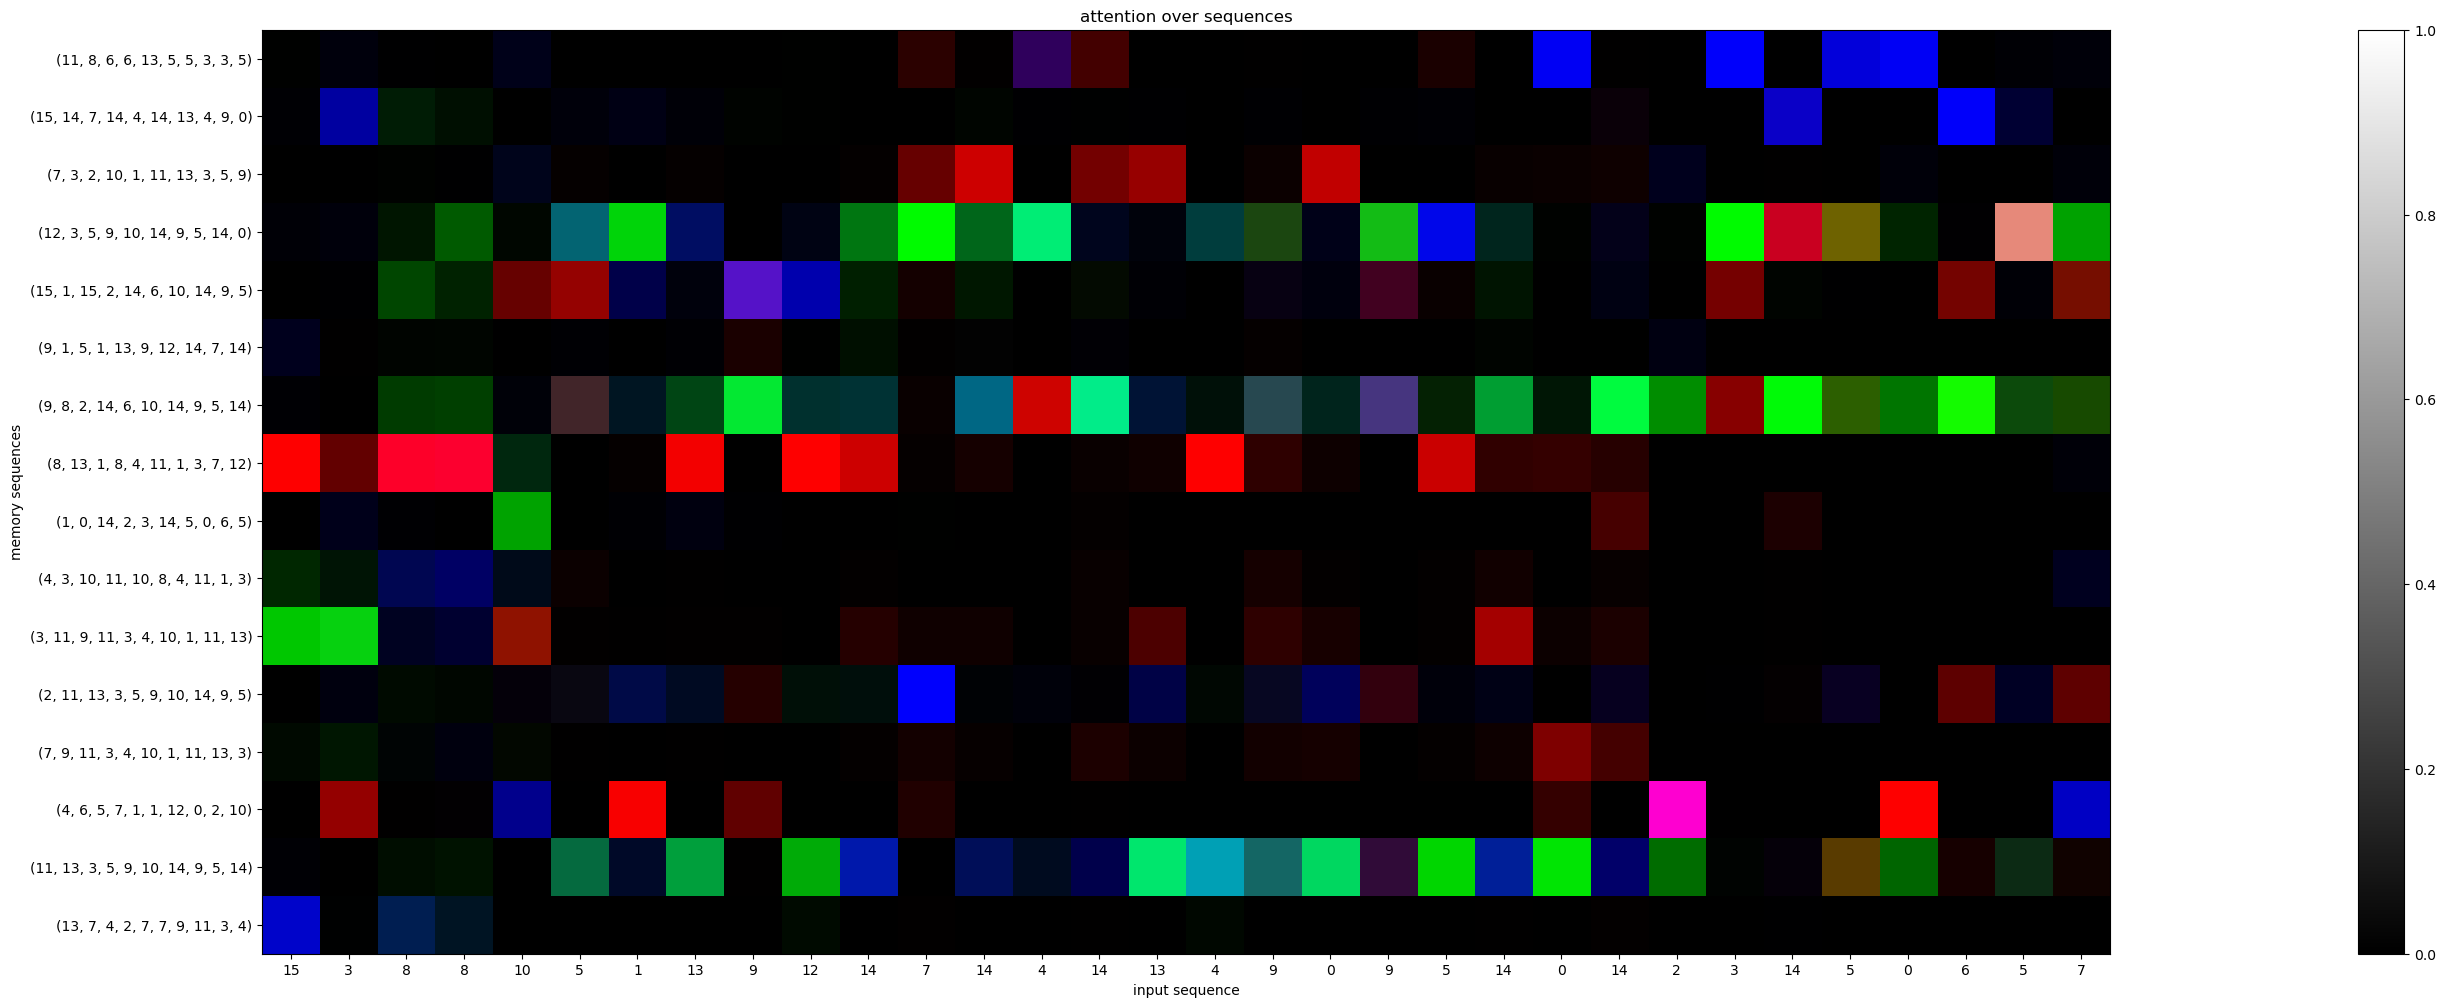

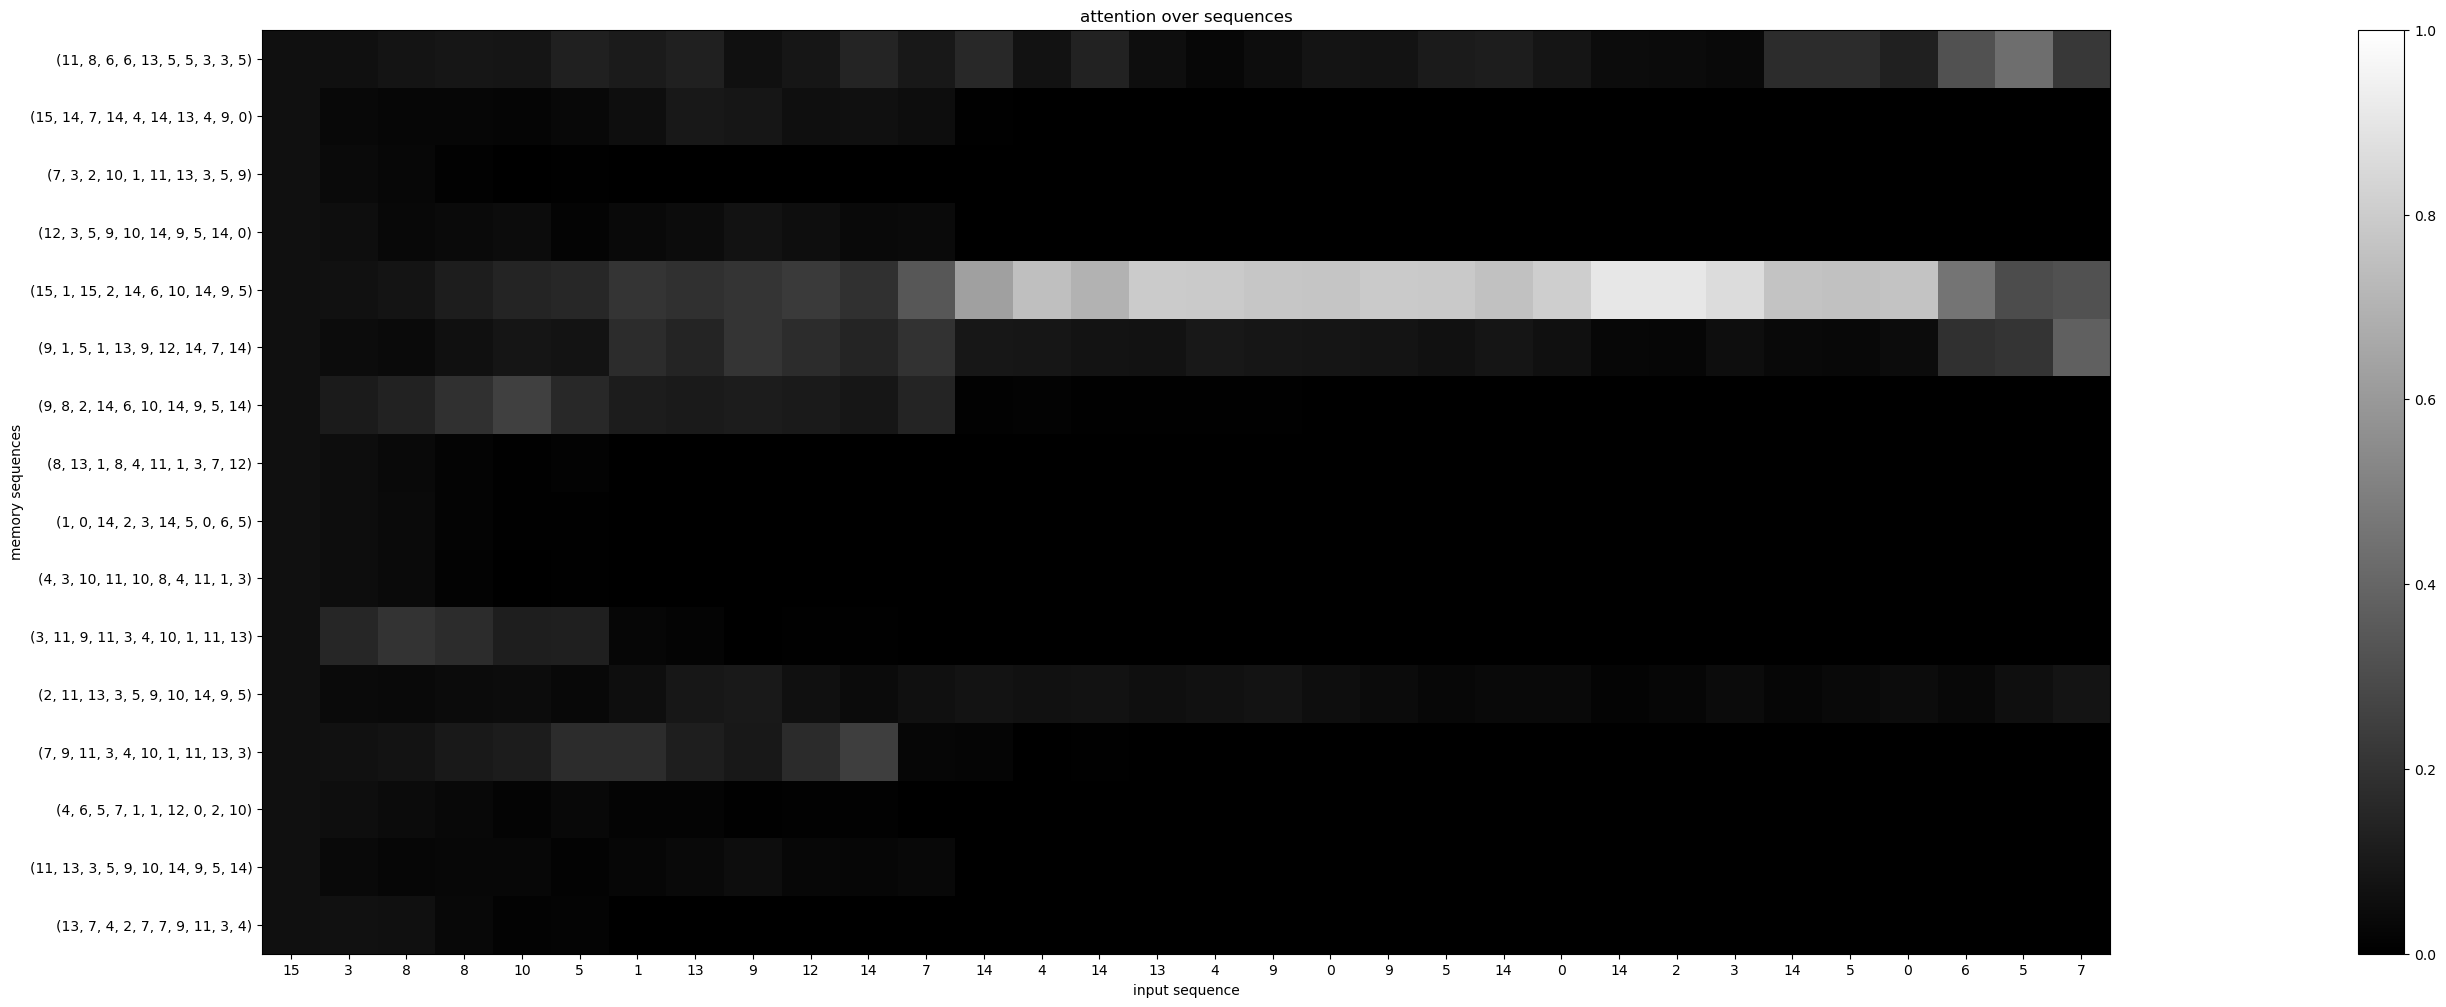

In [33]:
idx = np.random.choice(len(seqs_x_test))
print('memory_model1')
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model1)
print('memory_model2')
plot_attention_hierarchical(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
print('memory_model3')
plot_attention_cross_y(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)


## Robustness: change memory size at inference time

In [59]:
# sample memory buffers randomly
mem_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
data_dict = dict(mem_sizes=mem_sizes, model1_accs=[], model2_accs=[], model3_accs=[])

for mem_size in tqdm(mem_sizes):
    mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, 2*mem_size) for _ in range(n_test)])
    mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

    test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test), seqs_y_test)).batch(64)
    loss, acc = memory_model1.evaluate(test_ds)
    data_dict['model1_accs'].append(acc)

    test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)
    loss, acc = memory_model2.evaluate(test_ds)
    data_dict['model2_accs'].append(acc)

    loss, acc = memory_model3.evaluate(test_ds)
    data_dict['model3_accs'].append(acc)

  0%|          | 0/8 [00:00<?, ?it/s]

7/7 [==============================] - 1s 184ms/step - loss: 1.7051 - accuracy: 0.4561


 12%|█▎        | 1/8 [00:04<00:31,  4.48s/it]

7/7 [==============================] - 1s 195ms/step - loss: 1.6596 - accuracy: 0.4600


 25%|██▌       | 2/8 [00:09<00:27,  4.57s/it]

7/7 [==============================] - 2s 274ms/step - loss: 1.6246 - accuracy: 0.4699


 38%|███▊      | 3/8 [00:14<00:25,  5.08s/it]

7/7 [==============================] - 2s 266ms/step - loss: 1.6049 - accuracy: 0.4743


 50%|█████     | 4/8 [00:21<00:23,  5.77s/it]

7/7 [==============================] - 3s 404ms/step - loss: 1.5878 - accuracy: 0.4792


 62%|██████▎   | 5/8 [00:30<00:20,  6.77s/it]

7/7 [==============================] - 4s 556ms/step - loss: 1.5824 - accuracy: 0.4801


 75%|███████▌  | 6/8 [00:43<00:17,  8.83s/it]

7/7 [==============================] - 8s 1s/step - loss: 1.5795 - accuracy: 0.4842


 88%|████████▊ | 7/8 [01:09<00:14, 14.56s/it]

7/7 [==============================] - 13s 2s/step - loss: 1.5780 - accuracy: 0.4832


100%|██████████| 8/8 [01:49<00:00, 13.64s/it]


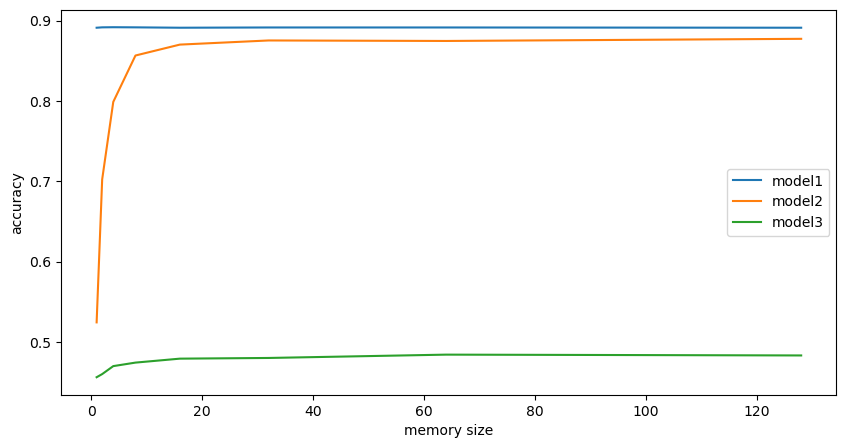

In [61]:
# plot_data
fig, ax = plt.subplots(figsize=(10, 5))
for i in (1,2,3):
    ax.plot(data_dict['mem_sizes'], data_dict[f'model{i}_accs'], label=f'model{i}')
ax.set_xlabel('memory size')
ax.set_ylabel('accuracy')
ax.legend()